In [1]:

from pathlib import Path

CSV_PATH = Path(r"C:\Users\hingz\Desktop\INST414\Module2\epi_r.csv")

TOP_N = 600      
MIN_COOC = 2     
RANDOM_SEED = 42

OUTPUT_DIR = Path("outputs_module2_wide")
OUTPUT_DIR.mkdir(exist_ok=True)

CSV_PATH, TOP_N, MIN_COOC, OUTPUT_DIR


(WindowsPath('C:/Users/hingz/Desktop/INST414/Module2/epi_r.csv'),
 600,
 2,
 WindowsPath('outputs_module2_wide'))

In [2]:

import pandas as pd
df_raw = pd.read_csv(CSV_PATH)

print("Rows:", len(df_raw))
print("Columns:", len(df_raw.columns))
print(list(df_raw.columns)[:20], "...")
df_raw.head(5)


Rows: 20052
Columns: 680
['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 'alabama', 'alaska', 'alcoholic', 'almond', 'amaretto', 'anchovy', 'anise', 'anniversary'] ...


,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:

import numpy as np
import re

df = df_raw.copy()

non_ing_cols = {"title","rating","calories","protein","fat","sodium"}
non_ing_cols |= {c for c in df.columns if c.lower() in non_ing_cols}

candidate_cols = []
for c in df.columns:
    if c in non_ing_cols:
        continue
    sn = pd.to_numeric(df[c], errors="coerce")
    vals = set(sn.dropna().unique().tolist())
    if vals.issubset({0,1}) and len(vals) > 0 and sn.sum() >= 5:
        candidate_cols.append(c)

print(f"Detected {len(candidate_cols)} indicator columns (sample):", candidate_cols[:25])

def looks_like_ingredient(name: str) -> bool:
    if len(name) > 30:
        return False
    if re.search(r"[\d/&]", name):  
        return False
    lname = name.lower()
    bad_tokens = [
        "day","party","week","bbq","barbecue","summer","winter","spring","fall",
        "super bowl","game night","city","state","country","festival","halloween","thanksgiving",
        "hanukkah","passover","kwanzaa","ramadan","easter","christmas","valentine","oktoberfest",
        "tested","improved","weelicious","cookbook","loves the microwave"
    ]
    if any(bt in lname for bt in bad_tokens):
        return False
    return True

candidate_cols = [c for c in candidate_cols if looks_like_ingredient(c)]
print("After ingredient-like filtering:", len(candidate_cols))

def row_to_ingredients(row):
    present = []
    for c in candidate_cols:
        v = row[c]
        try:
            v = float(v)
        except Exception:
            v = np.nan
        if not np.isnan(v) and v >= 0.5:
            present.append(c)
    return sorted(set(present))

df["ingredients_parsed"] = df.apply(row_to_ingredients, axis=1)
df["num_ingredients"] = df["ingredients_parsed"].apply(len)

print("Recipes with >=1 parsed items:", int((df["num_ingredients"] > 0).sum()))
df[["title"][:1] + ["num_ingredients","ingredients_parsed"]].head(5)


Detected 565 indicator columns (sample): ['#cakeweek', '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 'alcoholic', 'almond', 'amaretto', 'anchovy', 'anise', 'anniversary', 'aperitif', 'appetizer', 'apple', 'apple juice', 'apricot', 'arizona', 'artichoke', 'arugula', 'asian pear', 'asparagus', 'atlanta', 'australia', 'avocado', 'back to school']
After ingredient-like filtering: 510
Recipes with >=1 parsed items: 20046


,title,num_ingredients,ingredients_parsed
0,"Lentil, Apple, and Turkey Wrap",11,"[apple, bean, cookie, fruit, kid-friendly, len..."
1,Boudin Blanc Terrine with Red Onion Confit,9,"[bake, bon appétit, chill, dried fruit, food p..."
2,Potato and Fennel Soup Hodge,6,"[dairy, fennel, gourmet, new york, potato, veg..."
3,Mahi-Mahi in Tomato Olive Sauce,17,"[bon appétit, dairy free, dinner, fish, health..."
4,Spinach Noodle Casserole,9,"[bake, bon appétit, california, cheese, dairy,..."


In [4]:

from collections import Counter
import itertools

freq_all = Counter(itertools.chain.from_iterable(df["ingredients_parsed"]))
freq_df_dbg = (pd.DataFrame(freq_all.items(), columns=["ingredient","count"])
               .sort_values("count", ascending=False)
               .reset_index(drop=True))
freq_df_dbg.head(20)


,ingredient,count
0,bon appétit,9355
1,peanut free,8390
2,soy free,8088
3,tree nut free,7044
4,vegetarian,6846
5,gourmet,6648
6,kosher,6175
7,pescatarian,6042
8,bake,4413
9,dessert,3573


In [5]:

import itertools
from collections import Counter
import networkx as nx

def build_graph(df, TOP_N=300, MIN_COOC=2):
    freq = Counter(itertools.chain.from_iterable(df["ingredients_parsed"]))
    freq_df = (pd.DataFrame(freq.items(), columns=["ingredient","count"])
               .sort_values("count", ascending=False)
               .reset_index(drop=True))
    top_ings = set(freq_df.head(TOP_N)["ingredient"])

    edge_weights = Counter()
    for ings in df["ingredients_parsed"]:
        sub = sorted(top_ings.intersection(ings))
        for a, b in itertools.combinations(sub, 2):
            edge_weights[(a, b)] += 1

    G = nx.Graph()
    for ing in top_ings:
        G.add_node(ing, frequency=freq[ing])
    for (a,b), w in edge_weights.items():
        if w >= MIN_COOC:
            G.add_edge(a, b, weight=w)
    return G, freq_df

G, freq_df = build_graph(df, TOP_N=TOP_N, MIN_COOC=MIN_COOC)
print(f"[info] initial graph — nodes: {G.number_of_nodes()}  edges: {G.number_of_edges()}  (TOP_N={TOP_N}, MIN_COOC={MIN_COOC})")

if G.number_of_edges() == 0:
    if MIN_COOC > 1:
        G, freq_df = build_graph(df, TOP_N=TOP_N, MIN_COOC=1)
        print(f"[auto] lowered MIN_COOC to 1 — nodes: {G.number_of_nodes()}  edges: {G.number_of_edges()}")
    if G.number_of_edges() == 0 and TOP_N < 1000:
        G, freq_df = build_graph(df, TOP_N=1000, MIN_COOC=1)
        print(f"[auto] increased TOP_N to 1000 — nodes: {G.number_of_nodes()}  edges: {G.number_of_edges()}")

if G.number_of_edges() == 0:
    raise RuntimeError("Graph is empty. Consider loosening filters or thresholds.")

G.number_of_nodes(), G.number_of_edges()


[info] initial graph — nodes: 510  edges: 33578  (TOP_N=600, MIN_COOC=2)


(510, 33578)

In [6]:

import math

deg = nx.degree_centrality(G)
btw = nx.betweenness_centrality(G, normalized=True,
                                weight=lambda u,v,d: 1/max(d.get('weight',1),1))
pr  = nx.pagerank(G, weight='weight')

def top_list(d, k=15):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

deg_top = top_list(deg, 15)
btw_top = top_list(btw, 15)
pr_top  = top_list(pr,  15)

summary_nodes = set([n for n,_ in deg_top] + [n for n,_ in btw_top] + [n for n,_ in pr_top])
rows = [{
    "ingredient": n,
    "degree_centrality": deg.get(n, float("nan")),
    "betweenness_centrality": btw.get(n, float("nan")),
    "pagerank": pr.get(n, float("nan")),
    "frequency": G.nodes[n].get("frequency", float("nan")),
} for n in summary_nodes]
summary_df = pd.DataFrame(rows).sort_values(["pagerank","degree_centrality"], ascending=False)

display(pd.DataFrame({
    "degree_top": [x[0] for x in deg_top],
    "betweenness_top": [x[0] for x in btw_top],
    "pagerank_top": [x[0] for x in pr_top],
}))
summary_df.head(15)


,degree_top,betweenness_top,pagerank_top
0,bon appétit,bon appétit,peanut free
1,peanut free,peanut free,soy free
2,soy free,dessert,bon appétit
3,tree nut free,drink,tree nut free
4,kosher,vegetarian,vegetarian
5,pescatarian,gourmet,kosher
6,gourmet,soy free,pescatarian
7,vegetarian,dinner,gourmet
8,bake,bake,dairy free
9,dairy free,tree nut free,bake


,ingredient,degree_centrality,betweenness_centrality,pagerank,frequency
10,peanut free,0.944990,0.391277,0.041309,8390
15,soy free,0.941061,0.063037,0.039935,8088
9,bon appétit,0.950884,0.726397,0.036602,9355
1,tree nut free,0.913556,0.021181,0.034705,7044
8,vegetarian,0.831041,0.083741,0.031710,6846
13,kosher,0.884086,0.013839,0.031308,6175
4,pescatarian,0.854617,0.000187,0.030757,6042
3,gourmet,0.844794,0.063637,0.022394,6648
16,dairy free,0.805501,0.007860,0.017062,3206
21,bake,0.819253,0.033082,0.016879,4413


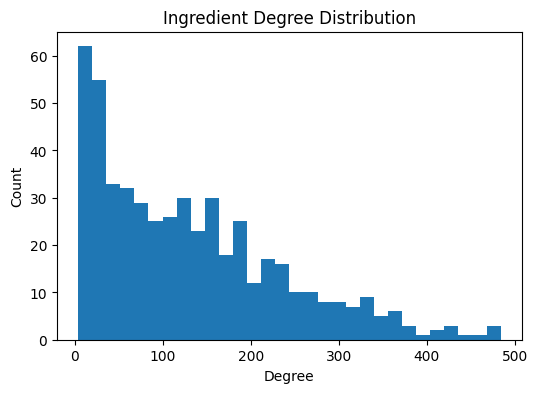

In [7]:

import matplotlib.pyplot as plt

deg_vals = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(6,4))
plt.hist(deg_vals, bins=30)
plt.title("Ingredient Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()


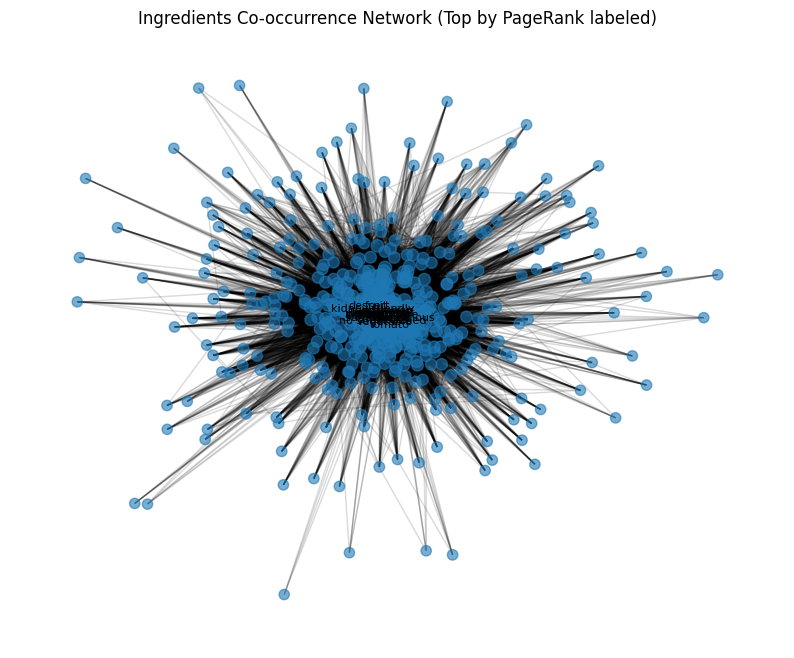

In [8]:

import math

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=RANDOM_SEED, k=0.15, weight='weight')

sizes = [min(3000, 50 + 2*math.sqrt(G.nodes[n]['frequency'])) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.15)

labels = {n: n for n,_ in sorted(nx.pagerank(G, weight='weight').items(), key=lambda x: x[1], reverse=True)[:25]}
nx.draw_networkx_labels(G, pos, labels, font_size=8)
plt.title("Ingredients Co-occurrence Network (Top by PageRank labeled)")
plt.axis("off")
plt.show()


In [9]:

summary_df.to_csv(OUTPUT_DIR / "ingredient_centrality_summary.csv", index=False)
freq_df.to_csv(OUTPUT_DIR / "ingredient_frequency.csv", index=False)
print("Saved:", OUTPUT_DIR / "ingredient_centrality_summary.csv")
print("Saved:", OUTPUT_DIR / "ingredient_frequency.csv")


Saved: outputs_module2_wide\ingredient_centrality_summary.csv
Saved: outputs_module2_wide\ingredient_frequency.csv
